## Modelo de detección de fraude para maximización de ganancia
### Andres Julián Jurado Castaño- Científico de Datos
#### 1. Análisis exploratorio
#### 2. Breve limpieza de datos
#### 3. Modelos

In [ ]:
#Versiones de paquetes estables para evitar conflictos entre paquetes
_=!pip install -r ./requirements.txt --upgrade

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:
data=pd.read_csv('./MercadoLibre Inc. Data Scientist Hiring Test - Fraud Dataset  - Data.csv',delimiter=',',
    thousands=',' )

### Análisis exploratorio

In [13]:
data.dtypes

A           int64
B           int64
C         float64
D           int64
E           int64
F         float64
G         float64
H           int64
I           int64
J          object
K         float64
L           int64
M           int64
N           int64
O           int64
P           int64
Q         float64
R         float64
S         float64
Monto     float64
Fraude      int64
dtype: object

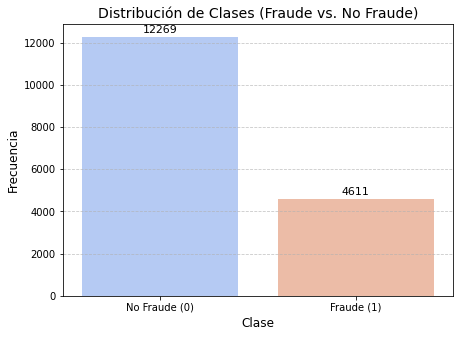

In [14]:
## Gráfico de barras para observar el desbalanceo
conteo = data['Fraude'].value_counts()

plt.figure(figsize=(7, 5)) 
sns.countplot(x='Fraude', data=data, palette='coolwarm')
plt.title('Distribución de Clases (Fraude vs. No Fraude)', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.xticks([0, 1], ['No Fraude (0)', 'Fraude (1)'])
for i, count in enumerate(conteo):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

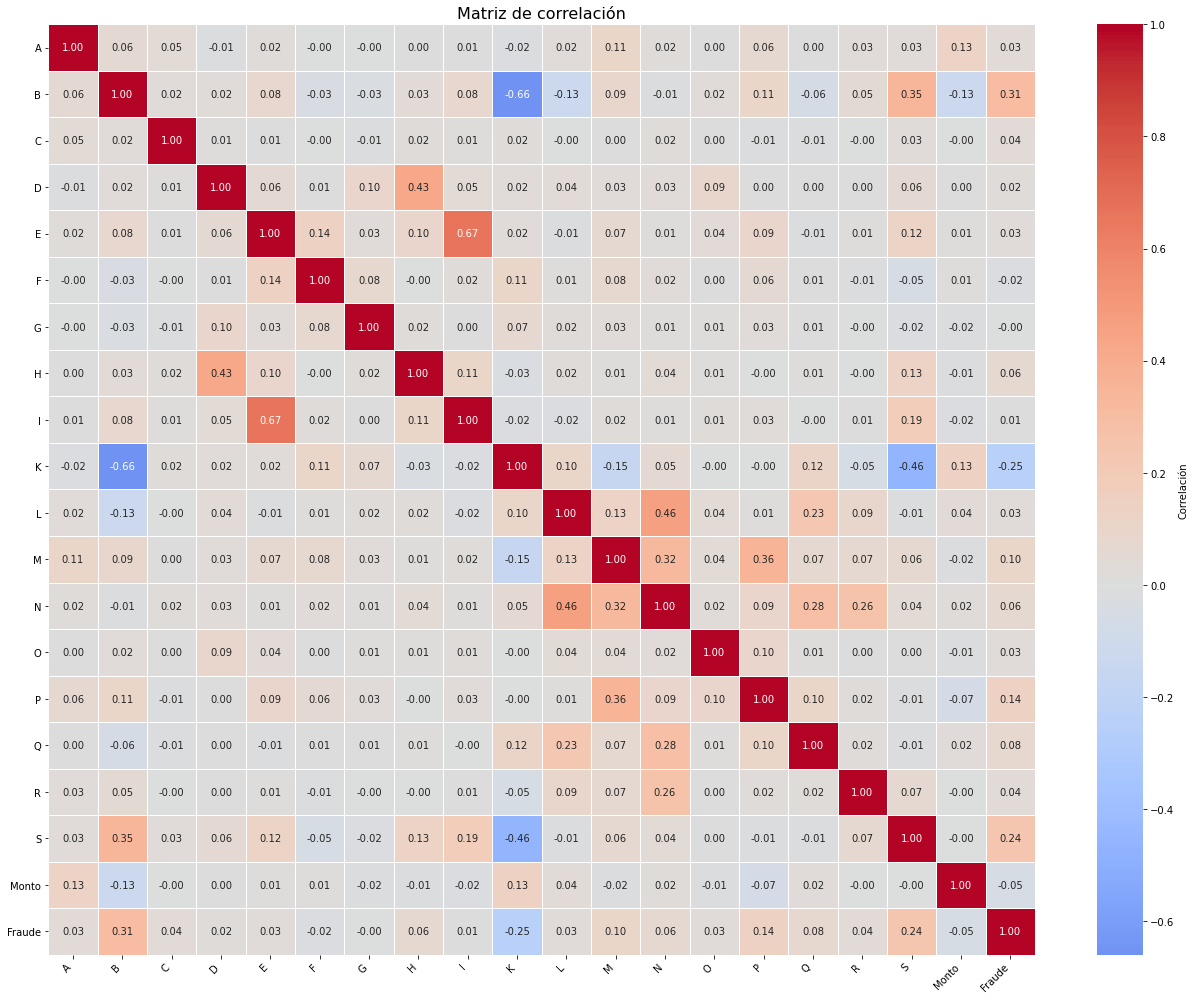

In [15]:
#matrix de correlaciones
#No se observa problemas de multicolinealidad
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(18, 14))  
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt=".2f", 
            linewidths=0.5,
            cbar_kws={'label': 'Correlación'})

plt.title('Matriz de correlación', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

#### Aunque la variable B y K tienen una correlación alta, la variable K tiene en su mayoria datos faltantes, de esta forma descartamos K y B puede decirse que contiene algo de información valiosa de K

In [16]:
data['Fraude'].groupby(data['J']).sum()

#mayor fraude en Argentina y brasil

J
AR    2626
AU       0
BR    1099
CA       0
CH       0
CL       0
CO       0
ES     295
FR       0
GB       0
GT       0
IT       0
KR       0
MX     216
PT       0
TR       0
UA       0
US     195
UY     180
Name: Fraude, dtype: int64

In [17]:
##Conteo de paises
## Se agrupan en 'Otros' locaciones por debajo de 10, para evitar sobredimesionar el data set
conteo_paises = data['J'].value_counts()
paises_raros = conteo_paises[conteo_paises < 10].index
data['J_agrupado'] = data['J'].replace(paises_raros, 'Otros')
print(data['J_agrupado'].value_counts())


J_agrupado
AR       9329
BR       4428
MX       2366
ES        314
US        230
UY        180
Otros      21
CA         12
Name: count, dtype: int64


In [ ]:
# Aplicar OHE a la columna agrupada
# Se elimina la columna K, al no tener conocimiento de lo que es y dada la cantidad de datos faltantes
data['K'].isna().sum()/len(data)

data = pd.get_dummies(data, columns=['J_agrupado'], prefix='Pais')
data.dtypes
data=data.drop(columns=['J','K'])


0.762085308056872

In [25]:
data['K'].isna().sum()

12864

In [79]:
data.dtypes

A               int64
B               int64
C             float64
D               int64
E               int64
F             float64
G             float64
H               int64
I               int64
L               int64
M               int64
N               int64
O               int64
P               int64
Q             float64
R             float64
S             float64
Monto         float64
Fraude          int64
Pais_AR          bool
Pais_BR          bool
Pais_CA          bool
Pais_ES          bool
Pais_MX          bool
Pais_Otros       bool
Pais_US          bool
Pais_UY          bool
dtype: object

In [80]:
#conteo de datos faltantes
data.isna().sum()

A                0
B                0
C             3197
D                0
E                0
F                0
G                0
H                0
I                0
L                0
M                0
N                0
O                0
P                0
Q                0
R                0
S                0
Monto            0
Fraude           0
Pais_AR          0
Pais_BR          0
Pais_CA          0
Pais_ES          0
Pais_MX          0
Pais_Otros       0
Pais_US          0
Pais_UY          0
dtype: int64

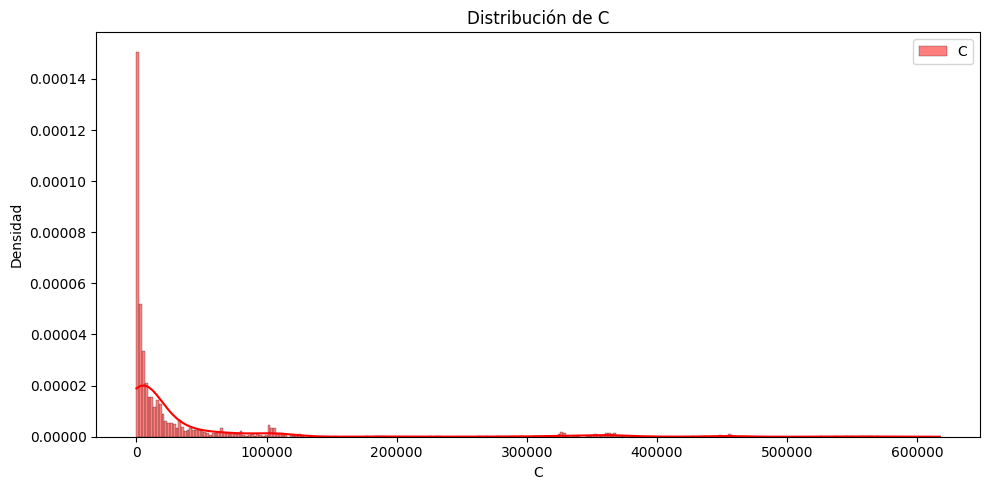

In [81]:
plt.figure(figsize=(10, 5))
sns.histplot(data['C'], color='red', label='C', kde=True, stat='density')
#sns.histplot(data['K'], color='blue', label='Sí operaron', kde=True, stat='density')
plt.title('Distribución de C')
plt.xlabel('C')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

In [82]:

# Dada la forma de la distribución de la Variable 'C' y teniendo en cuenta que tiene una pequeña cantidad de datos
# faltantes, es correcto imputar estos con la mediana
data['C'] = data['C'].fillna(data['C'].median())


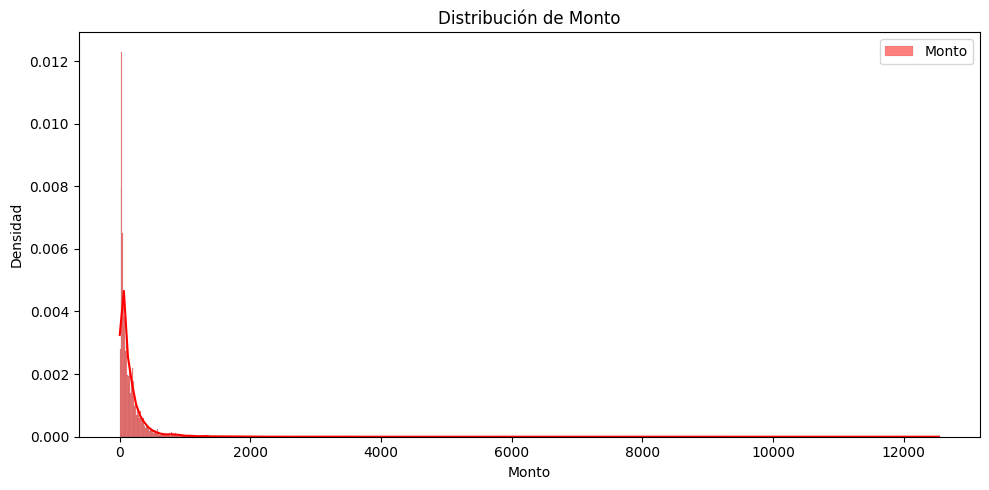

In [83]:
plt.figure(figsize=(10, 5))
sns.histplot(data['Monto'], color='red', label='Monto', kde=True, stat='density')
plt.title('Distribución de Monto')
plt.xlabel('Monto')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()

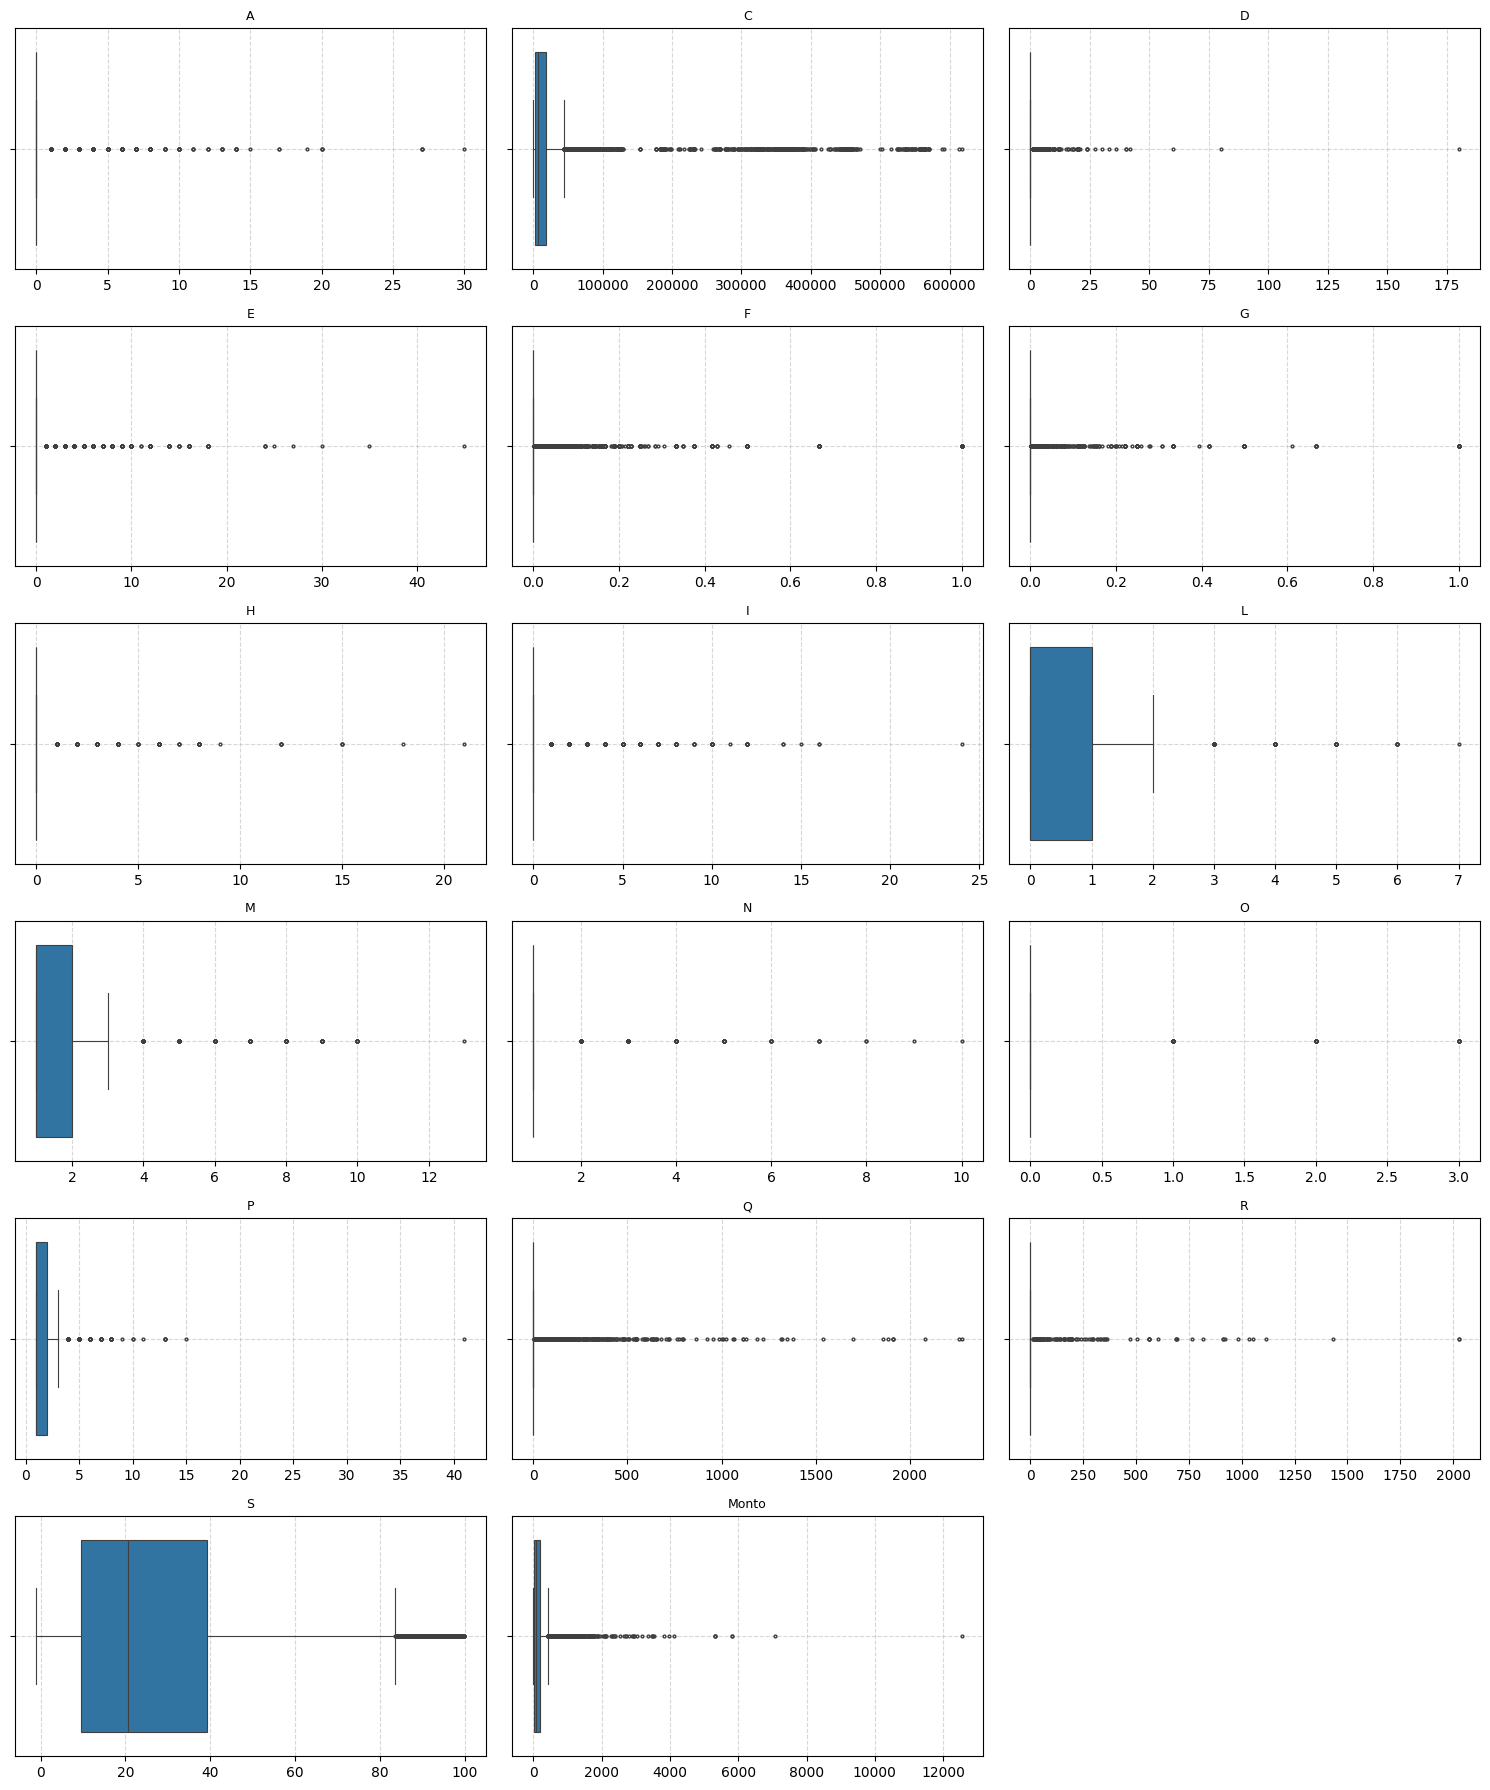

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
###detección de outliers
#Criterio del Rango Intercuartílico (IQR)
## se define outliers los valores que están por debajo del límite inferior y por encima del superior
numeric_df = data.select_dtypes(include='number')

non_binary_cols = [
    col for col in numeric_df.columns
    if numeric_df[col].dropna().nunique() > 2
]

columns_with_outliers = []
for col in non_binary_cols:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)]
    if not outliers.empty:
        columns_with_outliers.append(col)


n_cols = 3
n_plots = len(columns_with_outliers)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()


for i, col in enumerate(columns_with_outliers):
    sns.boxplot(x=data[col], ax=axes[i], linewidth=0.8, fliersize=2)
    axes[i].set_title(col, fontsize=9)
    axes[i].set_xlabel('')
    axes[i].grid(True, linestyle='--', alpha=0.5)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



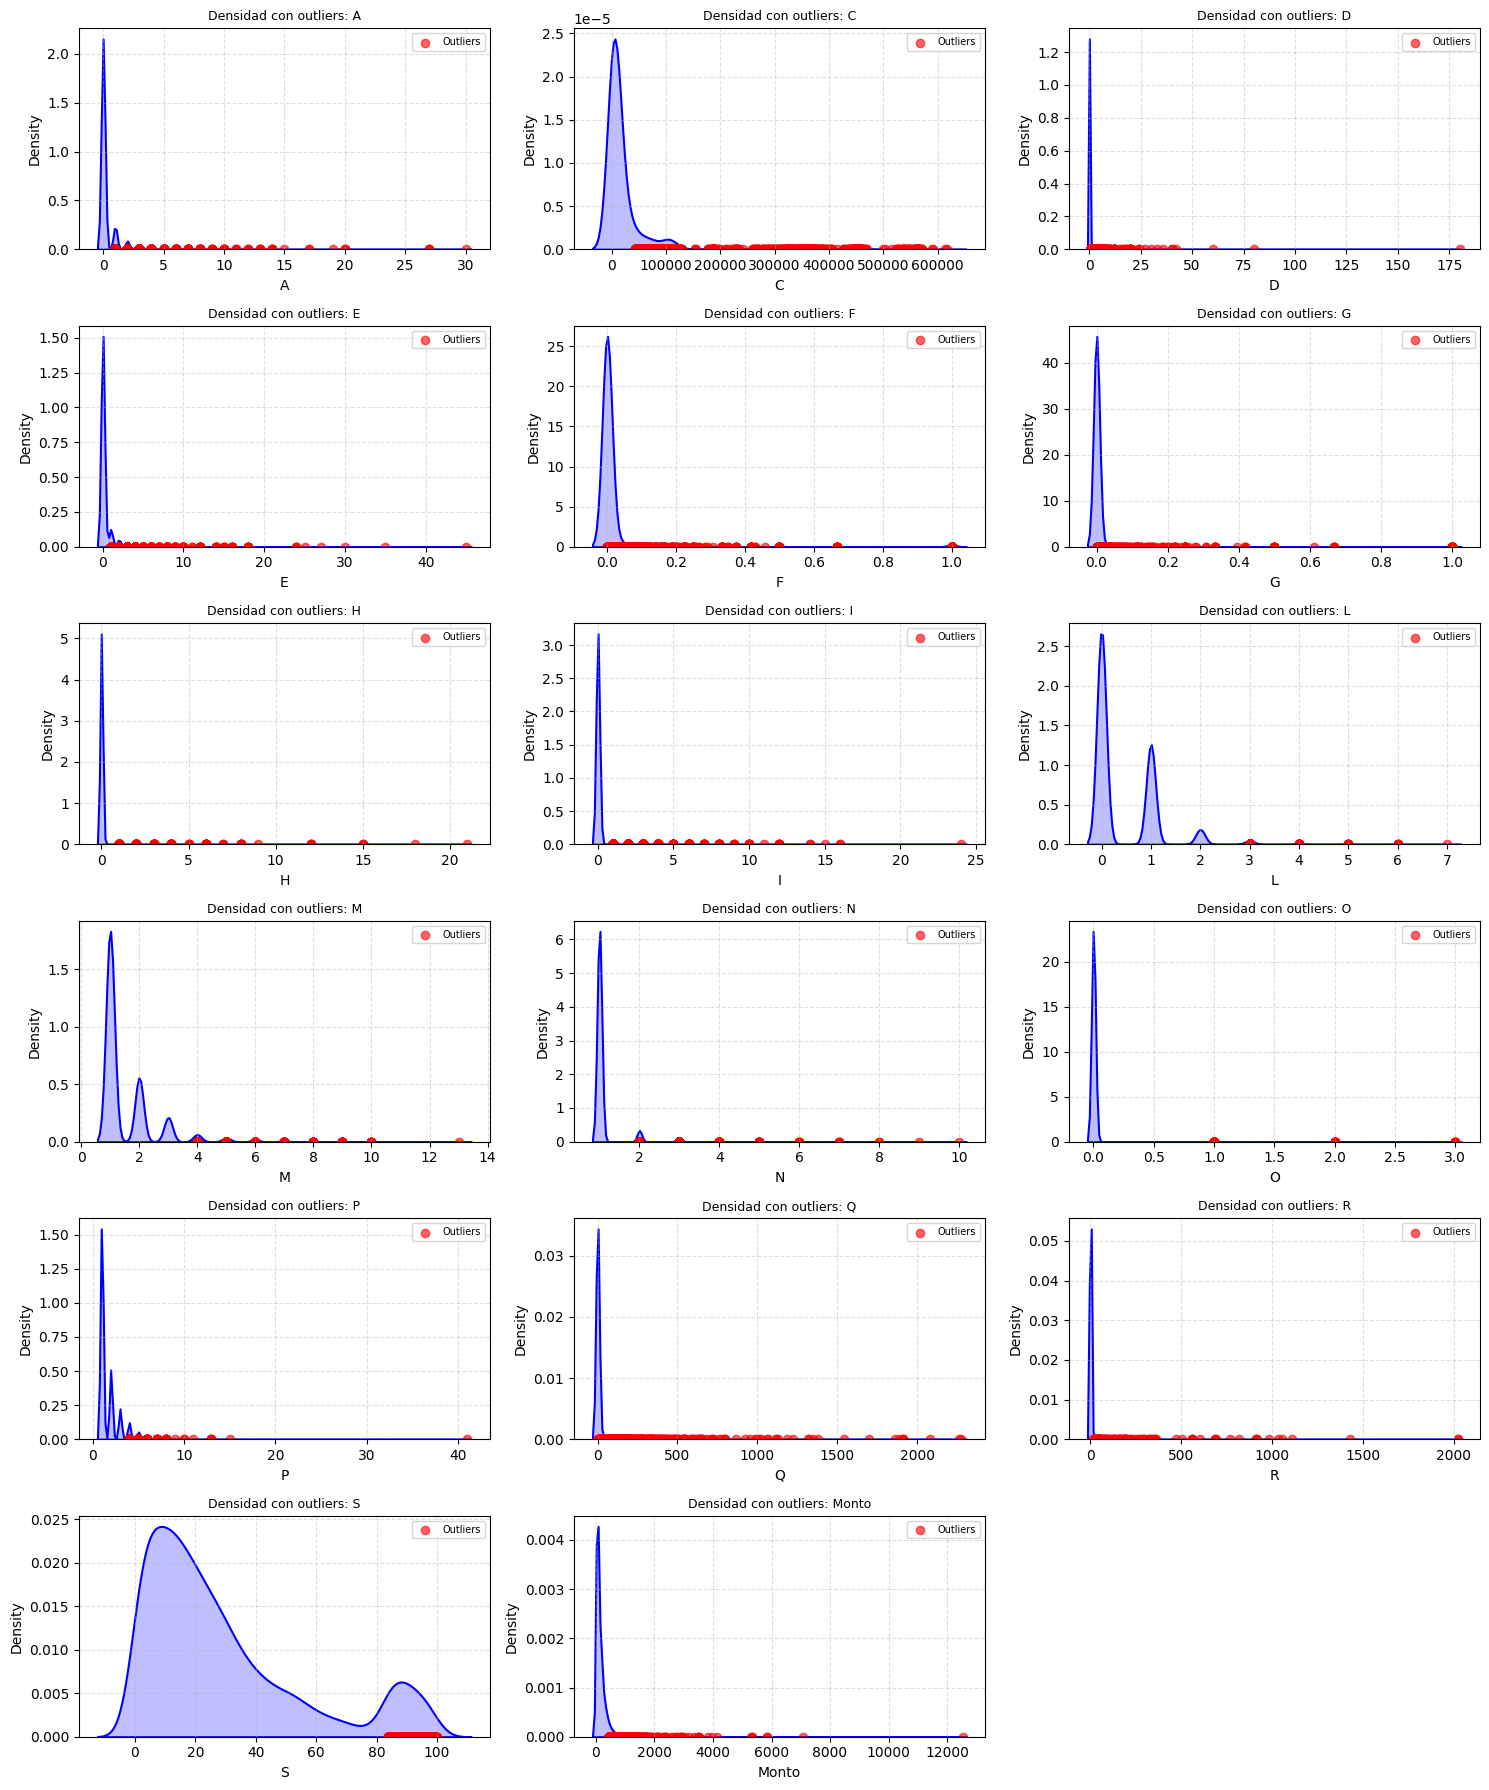

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Aunque existen outliers los modelos de arboles que uso, pueden manejar de manera correcta este tipo de datos
# al hacer pruebas de modelos, usar la transformación logaritmica en 'Monto' logró mejorar la capacidad predictiva de estos
non_binary_cols = [
    col for col in numeric_df.columns
    if numeric_df[col].dropna().nunique() > 2
]

columns_with_outliers = []
outliers_dict = {}

for col in non_binary_cols:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = numeric_df[(numeric_df[col] < lower) | (numeric_df[col] > upper)][col]
    if not outliers.empty:
        columns_with_outliers.append(col)
        outliers_dict[col] = outliers


n_cols = 3
n_plots = len(columns_with_outliers)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(columns_with_outliers):
    
    sns.kdeplot(data=numeric_df[col].dropna(), ax=axes[i], fill=True, linewidth=1.5, color='blue')
    
    
    axes[i].scatter(outliers_dict[col], [0] * len(outliers_dict[col]), color='red', alpha=0.6, label='Outliers')
    
    axes[i].set_title(f'Densidad con outliers: {col}', fontsize=9)
    axes[i].grid(True, linestyle='--', alpha=0.4)
    axes[i].legend(fontsize=7)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


$$
\text{Función objetivo personalizada}
$$
$$
\mathbf{Ganancia} = \sum_{i \in \text{Aprobadas}} \left[ (0.25 \times M_i) \cdot \mathbb{I}(y_{\text{verdaderos}, i} = 0) - (1.0 \times M_i) \cdot \mathbb{I}(y_{\text{verdaderos}, i} = 1) \right]
$$


$$
\mathbf{g_i = \frac{\partial L_i}{\partial \eta_i} = \begin{cases} 0.25 \cdot M_i \cdot p_i & \text{si } y_i = 0 \text{ (No Fraude)} \\ -1.0 \cdot M_i \cdot (1 - p_i) & \text{si } y_i = 1 \text{ (Fraude)} \end{cases}}
$$

$$
\mathbf{h_i = \frac{\partial^2 L_i}{\partial \eta_i^2} = \begin{cases} 0.25 \cdot M_i \cdot p_i (1 - p_i) & \text{si } y_i = 0 \text{ (No Fraude)} \\ 1.0 \cdot M_i \cdot p_i (1 - p_i) & \text{si } y_i = 1 \text{ (Fraude)} \end{cases}}
$$

$$
\mathbf{Ganacia_{total}} = \left( 0.25 \sum_{i \in \text{TN}} M_i \right) - \left( 1.0 \sum_{i \in \text{FN}} M_i \right)
$$

$$
\begin{array}{|l|l|}
\hline
\textbf{Símbolo} & \textbf{Descripción} \\
\hline
\mathbf{M_i} & \text{Monto de la Transacción. Utilizado como peso para el impacto económico.} \\
\hline
\mathbf{y_i} & \text{Etiqueta Verdadera binaria } (0: \text{No Fraude}, 1: \text{Fraude}). \\
\hline
\mathbf{\eta_i} & \text{Log-Odds (Predicción Bruta). La variable que el modelo optimiza.} \\
\hline
\mathbf{p_i} & \text{Probabilidad Predicha de fraude } (p_i = \sigma(\eta_i)). \\
\hline
\mathbf{\mathbb{I}(\cdot)} & \text{Función Indicadora. Devuelve } 1 \text{ si la condición es cierta.} \\
\hline
\mathbf{\mathcal{L}_i} & \text{Pérdida Económica } (\mathcal{L}_i = -\mathbf{Ganancia}_i). \\
\hline
\mathbf{g_i} & \text{Gradiente } (\frac{\partial \mathcal{L}_i}{\partial \eta_i}). \text{ Indica la dirección del error.} \\
\hline
\mathbf{h_i} & \text{Hessiano } (\frac{\partial^2 \mathcal{L}_i}{\partial \eta_i^2}). \text{ Determina la curvatura y estabilidad.} \\
\hline
\mathbf{TN} & \text{Verdaderos Negativos en fraude (Legítimo aprobado).} \\
\hline
\mathbf{FN} & \text{Falsos Negativos (Fraude aprobado).} \\
\hline
\end{array}
$$

In [ ]:
## Función Personalizada para evaluar el modelo con respecto a necesidad de negocio

def Ganancia(y_pred, dtrain):
    """
    Función de pérdida diferenciada según el monto y tipo de error.
    Penaliza más los fraudes aprobados y recompensa las transacciones legítimas aprobadas.
    """
    y_true = dtrain.get_label()
    ##Ponderación basado en la pérdida de la ganancia
    # Prioriza perdidas de montos altos
    monto = dtrain.get_weight()

    # Probabilidad predicha (transformación sigmoide) para el gradiente
    p = 1.0 / (1.0 + np.exp(-y_pred))

    # Gradiente y Hessiano basados en pérdidas económicas necesario para XGboost
    grad = np.where(
        y_true == 1,  # Fraude
        -monto * (1 - p),  # penalización fuerte si el modelo aprueba
        -0.25 * monto * (0 - p)  # recompensa leve si aprueba verdaderos
    )
    #hessiano
    hess = np.where(
        y_true == 1,
        monto * p * (1 - p),
        0.25 * monto * p * (1 - p)
    )
    return grad, hess


def ganancia_total(y_true, y_pred_proba, monto, threshold):
    """
    Calcula la Ganancia Neta Total basada en un umbral de decisión específico.
    Esta función es usada para encontrar el 'threshold' o umbral óptimo que maximiza
    el beneficio económico del modelo en el conjunto de prueba.

    El cálculo se basa únicamente en las transacciones APROBADAS (y_pred == 0).

    


    Retorna:
    --------
    float: Ganancia Neta Total en moneda.

    Lógica:
    - Ganancia (0.25 * Monto): Por Verdaderos Negativos  en fraude (VN): verdadero aprobado.
    - Pérdida (-1.0 * Monto): Por Falsos Negativos (FN): Fraude Aprobado (máxima pérdida).
    """

    y_pred = (y_pred_proba >= threshold).astype(int)

    ganancia = (

     0.25 * monto[(y_pred == 0) & (y_true == 0)].sum()

    - 1.0 * monto[(y_pred == 0) & (y_true == 1)].sum()

     )

    return ganancia

### Modelo XGboost, con función de gananacia total.

[0]	train-auc:0.77900	eval-auc:0.72577
[50]	train-auc:0.86508	eval-auc:0.80612
[100]	train-auc:0.88937	eval-auc:0.81626
[150]	train-auc:0.91089	eval-auc:0.82249
[200]	train-auc:0.92465	eval-auc:0.82813
[250]	train-auc:0.93641	eval-auc:0.82878
[300]	train-auc:0.94848	eval-auc:0.82902
[350]	train-auc:0.95523	eval-auc:0.82993
[379]	train-auc:0.95922	eval-auc:0.82855

 Umbral óptimo (ganancia): 0.488
 Ganancia máxima esperada: 75,446

AUC-ROC: 0.8201


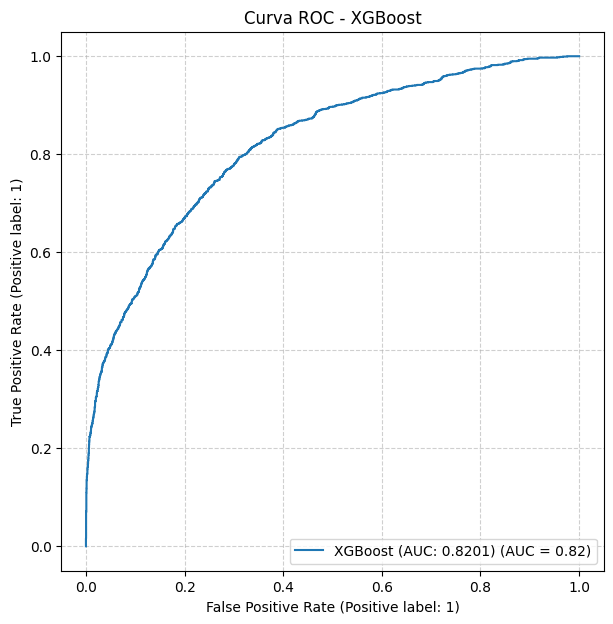

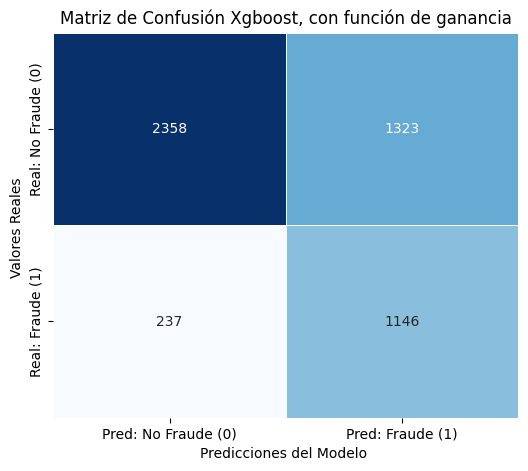


Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.91      0.64      0.75      3681
      Fraude       0.46      0.83      0.60      1383

    accuracy                           0.69      5064
   macro avg       0.69      0.73      0.67      5064
weighted avg       0.79      0.69      0.71      5064



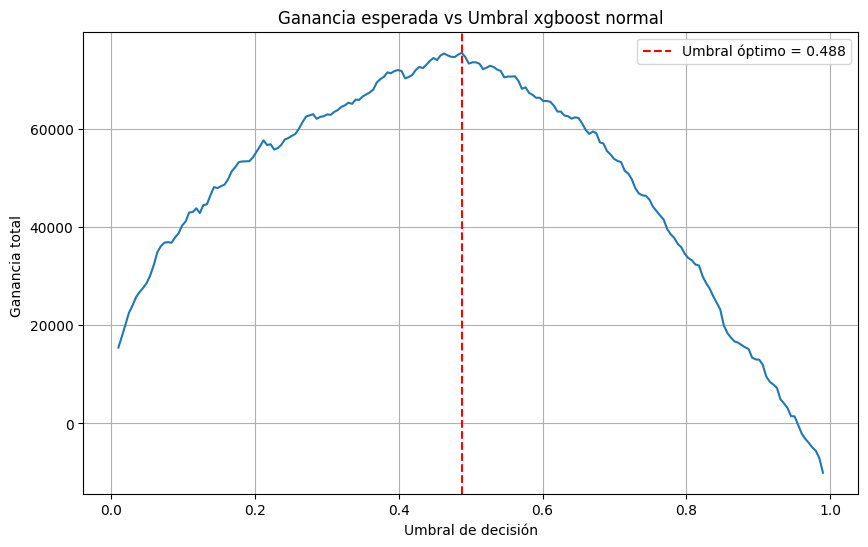

In [ ]:

from xgboost import XGBClassifier, DMatrix, train
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay


X = data.drop(['Fraude'], axis=1)

y = data['Fraude']
monto = data['Monto'].copy()
## Split con estratificación
X_train, X_test, y_train, y_test, monto_train, monto_test = train_test_split(
    X, y, monto, test_size=0.3, random_state=42, stratify=y
)


# Entrenamiento

dtrain = DMatrix(X_train, label=y_train, weight=monto_train)
dtest = DMatrix(X_test, label=y_test, weight=monto_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

model = train(
    params,
    dtrain,
    num_boost_round=380,
    obj=Ganancia, ## Aplicación de la función customizada
    evals=evallist,
    early_stopping_rounds=50, # Detiene el entrenamiento si no hay mejora en 50 rondas
    verbose_eval=50
)
## Predicciones y Ganancia teniendo en cuenta el umbral que maximiza esta ganancia

y_pred_proba = model.predict(dtest)


##200 posibles umbrales 
umbrales = np.linspace(0.01, 0.99, 200)
ganancias = [ganancia_total(y_test, y_pred_proba, monto_test, t) for t in umbrales]

t_opt = umbrales[np.argmax(ganancias)]
gan_max = max(ganancias)

print(f"\n Umbral óptimo (ganancia): {t_opt:.3f}")
print(f" Ganancia máxima esperada: {gan_max:,.0f}")


y_pred_final = (y_pred_proba >= t_opt).astype(int)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAUC-ROC: {auc:.4f}")
plt.figure(figsize=(7, 7))

RocCurveDisplay.from_predictions(
    y_test, 
    y_pred_proba, 
    ax=plt.gca(), 
    name=f"XGBoost (AUC: {auc:.4f})"
)
plt.title('Curva ROC - XGBoost')
plt.grid(linestyle='--', alpha=0.6)
plt.show()


# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))

sns.heatmap(
    conf_matrix, 
    annot=True,             
    fmt='d',               
    cmap='Blues',            
    linewidths=.5,          
    cbar=False,              
    xticklabels=['Pred: No Fraude (0)', 'Pred: Fraude (1)'],
    yticklabels=['Real: No Fraude (0)', 'Real: Fraude (1)']
)
plt.title('Matriz de Confusión Xgboost, con función de ganancia')
plt.ylabel('Valores Reales ')
plt.xlabel('Predicciones del Modelo ')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['No Fraude', 'Fraude']))

##Gráfica de la ganancia

plt.figure(figsize=(10, 6))
plt.plot(umbrales, ganancias)
plt.axvline(x=t_opt, color='red', linestyle='--', label=f'Umbral óptimo = {t_opt:.3f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('Ganancia total ')
plt.title('Ganancia esperada vs Umbral xgboost normal')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest con Optimización Bayesiana

Iniciando Optimización Bayesiana para Random Forest...
 Mejores Hiperparámetros RF (Bayesiana): OrderedDict([('class_weight', None), ('max_depth', 15), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
 Mejor AUC de CV (Bayesiana): 0.8169

 Umbral óptimo RF (ganancia en test): 0.241
 Ganancia máxima esperada RF: 70,379

AUC-ROC RF (test): 0.8159


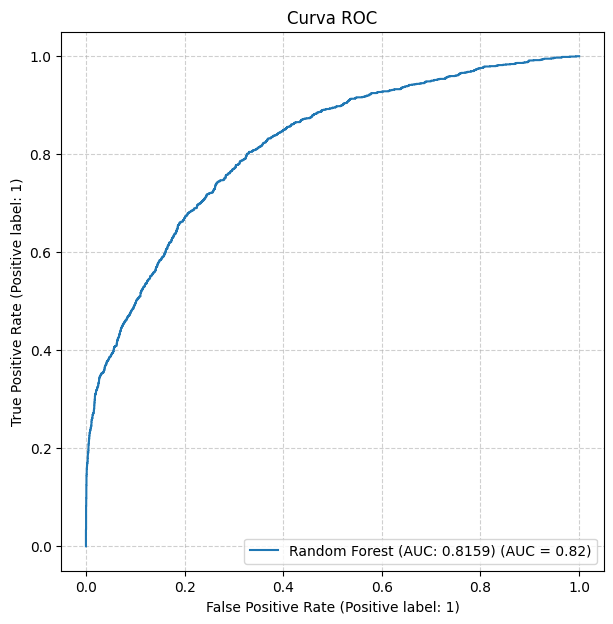


Reporte de Clasificación RF:
              precision    recall  f1-score   support

   No Fraude       0.90      0.67      0.77      3681
      Fraude       0.48      0.80      0.60      1383

    accuracy                           0.71      5064
   macro avg       0.69      0.74      0.68      5064
weighted avg       0.79      0.71      0.72      5064



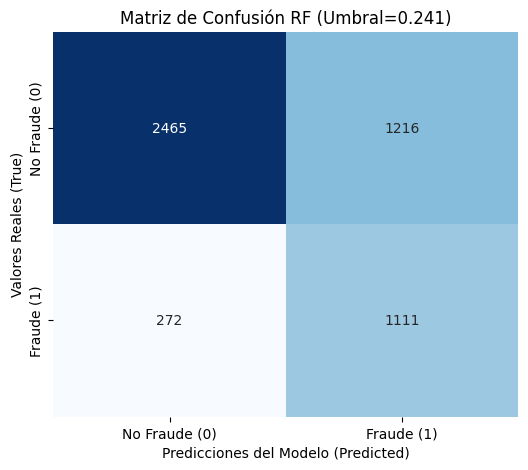

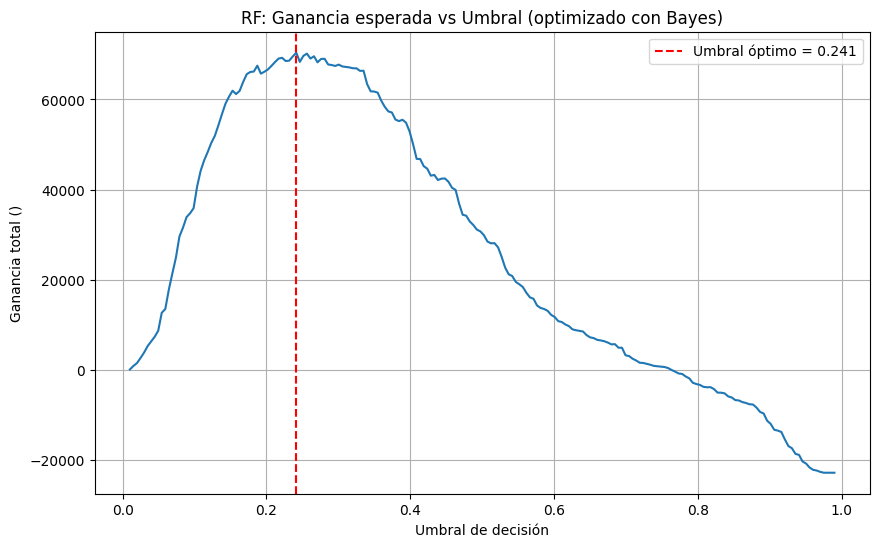

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, make_scorer, RocCurveDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Integer



# Usamos AUC-ROC como métrica de CV para BayesSearchCV, ya que RF no admite la función personalizada por su naturaleza
# de construcción.
scorer_auc = make_scorer(roc_auc_score, needs_proba=True)

# Definición del espacio de búsqueda para Random Forest
param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(5, 15),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'class_weight': ['balanced', None] 
}

# Inicializar Random Forest con hiperparámetros base
rf_base = RandomForestClassifier(random_state=42)

# Inicializar Optimización Bayesiana 
opt = BayesSearchCV(
    rf_base,
    param_space,
    n_iter=30, # Número total de iteraciones de búsqueda
    cv=5,      # 5-fold Cross-Validation
    scoring=scorer_auc,
    random_state=42,
    n_jobs=-1  # Usar todos los cores
)

print("Iniciando Optimización Bayesiana para Random Forest...")
opt.fit(X_train, y_train)

# Mejor modelo RF
rf_model = opt.best_estimator_
print(f" Mejores Hiperparámetros RF (Bayesiana): {opt.best_params_}")
print(f" Mejor AUC de CV (Bayesiana): {opt.best_score_:.4f}")


#  Predicciones y optimización en test


y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calcular Ganancia para todos los umbrales en el set de test
umbrales = np.linspace(0.01, 0.99, 200)
ganancias_rf = [ganancia_total(y_test, y_pred_proba_rf, monto_test, t) for t in umbrales]

t_opt_rf = umbrales[np.argmax(ganancias_rf)]
gan_max_rf = max(ganancias_rf)

print(f"\n Umbral óptimo RF (ganancia en test): {t_opt_rf:.3f}")
print(f" Ganancia máxima esperada RF: {gan_max_rf:,.0f}")

#Evaluación de gráficos

y_pred_final_rf = (y_pred_proba_rf >= t_opt_rf).astype(int)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"\nAUC-ROC RF (test): {auc_rf:.4f}")


plt.figure(figsize=(7, 7))
RocCurveDisplay.from_predictions(y_test, y_pred_proba_rf, ax=plt.gca(), name=f"Random Forest (AUC: {auc_rf:.4f})")
plt.title('Curva ROC')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

print("\nReporte de Clasificación RF:")
print(classification_report(y_test, y_pred_final_rf, target_names=['No Fraude', 'Fraude']))



#Gráfico de la Matriz de Confusión (Heatmap)
conf_matrix = confusion_matrix(y_test, y_pred_final_rf)
labels = ['No Fraude (0)', 'Fraude (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f'Matriz de Confusión RF (Umbral={t_opt_rf:.3f})')
plt.ylabel('Valores Reales (True)')
plt.xlabel('Predicciones del Modelo (Predicted)')
plt.show() 

##Gráfico de la Ganancia vs Umbral
plt.figure(figsize=(10, 6))
plt.plot(umbrales, ganancias_rf)
plt.axvline(x=t_opt_rf, color='red', linestyle='--', label=f'Umbral óptimo = {t_opt_rf:.3f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('Ganancia total ()')
plt.title('RF: Ganancia esperada vs Umbral (optimizado con Bayes)')
plt.legend()
plt.grid(True)
plt.show()

### XGboost con optimización Bayesiana y función personalizada de Ganancia

Iniciando Optimización Bayesiana para XGBoost (usando AUC)...


c:\Users\andres.jurado\Anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Mejores Hiperparámetros XGBoost (Bayesiana): OrderedDict([('colsample_bytree', 0.7), ('learning_rate', 0.015347246810065806), ('max_depth', 8), ('n_estimators', 600), ('subsample', 0.7)])
 Mejor AUC (Bayesiana): 0.8252


c:\Users\andres.jurado\Anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:24:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 Umbral óptimo XGBoost (ganancia en test): 0.458
 Ganancia máxima esperada XGBoost: 70,349

AUC-ROC XGBoost (test): 0.8057


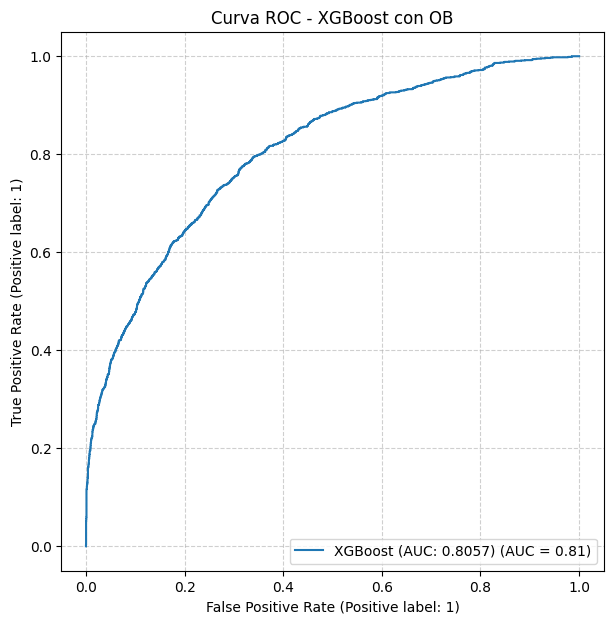

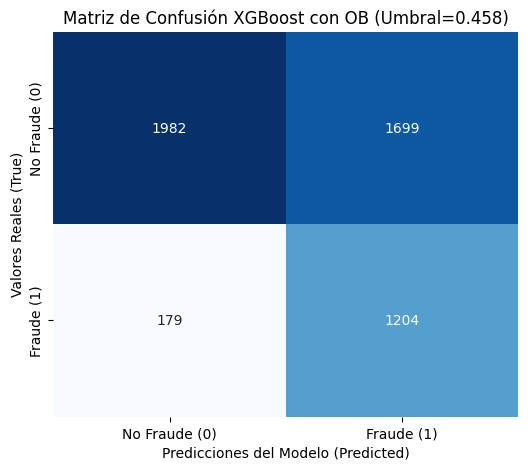


Reporte de Clasificación XGBoost:
              precision    recall  f1-score   support

   No Fraude       0.92      0.54      0.68      3681
      Fraude       0.41      0.87      0.56      1383

    accuracy                           0.63      5064
   macro avg       0.67      0.70      0.62      5064
weighted avg       0.78      0.63      0.65      5064



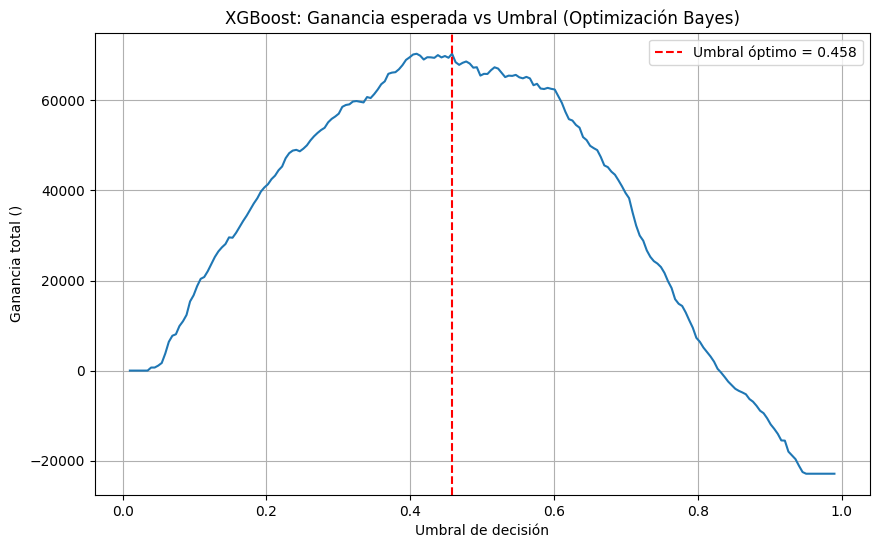

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, DMatrix, train
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, make_scorer, RocCurveDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Integer





scorer_auc = make_scorer(roc_auc_score, needs_proba=True)

# Espacio de búsqueda para XGBoost
param_space_xgb = {
    'n_estimators': Integer(100, 600),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'subsample': Real(0.7, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.7, 1.0, prior='uniform'),
}

xgb_base = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)

opt_xgb = BayesSearchCV(
    xgb_base,
    param_space_xgb,
    n_iter=30, 
    cv=3,       # Reducido a cv=3 para mayor velocidad
    scoring=scorer_auc,
    random_state=42,
    n_jobs=-1
)

print("Iniciando Optimización Bayesiana para XGBoost (usando AUC)...")
# Usamos fit() con los datos de entrenamiento
opt_xgb.fit(X_train, y_train) 

# Resultados de la Optimización Bayesiana
best_params_xgb = opt_xgb.best_params_
print(f" Mejores Hiperparámetros XGBoost (Bayesiana): {best_params_xgb}")
print(f" Mejor AUC (Bayesiana): {opt_xgb.best_score_:.4f}")


 


# Creamos los DMatrix necesarios
dtrain = DMatrix(X_train, label=y_train, weight=monto_train)
dtest = DMatrix(X_test, label=y_test, weight=monto_test)

# Parámetros finales (incluimos los óptimos encontrados por BayesSearchCV)
params_final = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'random_state': 42,
    **best_params_xgb # Desempaquetar los mejores hiperparámetros
}
#Entrenamiento con los parámetros óptimos y la función personalizada
model_final = train(
    params_final,
    dtrain,
    num_boost_round=params_final['n_estimators'], # Usar el n_estimators óptimo
    obj=Ganancia, # Usamos la función de pérdida personalizada
    evals=[(dtest, 'eval')],
    early_stopping_rounds=20, 
    verbose_eval=False
)

# Resultados de la Predicción Final
y_pred_proba_final = model_final.predict(dtest)

# Calcular Ganancia para todos los umbrales en el set de test
umbrales = np.linspace(0.01, 0.99, 200)
ganancias_final = [ganancia_total(y_test, y_pred_proba_final, monto_test, t) for t in umbrales]

t_opt_final = umbrales[np.argmax(ganancias_final)]
gan_max_final = max(ganancias_final)

print(f"\n Umbral óptimo XGBoost (ganancia en test): {t_opt_final:.3f}")
print(f" Ganancia máxima esperada XGBoost: {gan_max_final:,.0f}")


#Evaluación

y_pred_final_xgb = (y_pred_proba_final >= t_opt_final).astype(int)
auc_xgb = roc_auc_score(y_test, y_pred_proba_final)

print(f"\nAUC-ROC XGBoost (test): {auc_xgb:.4f}")

#  Gráfico de la Curva ROC (AUC) 
plt.figure(figsize=(7, 7))
RocCurveDisplay.from_predictions(y_test, y_pred_proba_final, ax=plt.gca(), name=f"XGBoost (AUC: {auc_xgb:.4f})")
plt.title('Curva ROC - XGBoost con OB')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

#Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_final_xgb)
labels = ['No Fraude (0)', 'Fraude (1)']

plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f'Matriz de Confusión XGBoost con OB (Umbral={t_opt_final:.3f})')
plt.ylabel('Valores Reales (True)')
plt.xlabel('Predicciones del Modelo (Predicted)')
plt.show()

#  Reporte de Clasificación 
print("\nReporte de Clasificación XGBoost:")
print(classification_report(y_test, y_pred_final_xgb, target_names=['No Fraude', 'Fraude']))

#  Visualizar Ganancia vs Umbral 
plt.figure(figsize=(10, 6))
plt.plot(umbrales, ganancias_final)
plt.axvline(x=t_opt_final, color='red', linestyle='--', label=f'Umbral óptimo = {t_opt_final:.3f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('Ganancia total ()')
plt.title('XGBoost: Ganancia esperada vs Umbral (Optimización Bayes)')
plt.legend()
plt.grid(True)
plt.show()